In [248]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
#first, load 3 datasets

add1="C:/Users/YUNUS/Downloads/ml2_project/data/u.base"
add2="C:/Users/YUNUS/Downloads/ml2_project/data/u.test"
add3="C:/Users/YUNUS/Downloads/ml2_project/data/u.item"

ratings=pd.read_csv(add1,header=None,names=["userid","filmid","rating","timestamp"], sep="\t")
ratings_test=pd.read_csv(add2,header=None,names=["userid","filmid","rating","timestamp"], sep="\t")



data={"filmid":[],"film_name":[],"release_date":[], "website":[],"unknown":[],"Action":[],"Adventure":[],"Animation":[],
      "Children's":[],"Comedy":[],"Crime":[],"Documentary":[],"Drama":[],"Fantasy":[],
"Film-Noir":[],"Horror":[],"Musical":[],"Mystery":[],"Romance":[],"Sci-Fi":[],"Thriller":[],"War":[],"Western":[]}

with open(add3, mode='r') as file:
    for line in file:
        items=line.strip().split('|')
        data["filmid"].append(items[0])
        data["film_name"].append(items[1])
        data["release_date"].append(items[2])
        data["website"].append(items[4])
        data["unknown"].append(items[5])
        data["Action"].append(items[6])
        data["Adventure"].append(items[7])
        data["Animation"].append(items[8])
        data["Children's"].append(items[9])
        data["Comedy"].append(items[10])
        data["Crime"].append(items[11])
        data["Documentary"].append(items[12])
        data["Drama"].append(items[13])
        data["Fantasy"].append(items[14])
        data["Film-Noir"].append(items[15])
        data["Horror"].append(items[16])
        data["Musical"].append(items[17])
        data["Mystery"].append(items[18])
        data["Romance"].append(items[19])
        data["Sci-Fi"].append(items[20])
        data["Thriller"].append(items[21])
        data["War"].append(items[22])
        data['Western'].append(items[23])
        
dtypes={"filmid":int,"film_name":str,"release_date":str, "website":str,"unknown":int,"Action":int,"Adventure":int,
      "Animation":int,"Children's":int,"Comedy":int,"Crime":int,"Documentary":int,"Drama":int,
      "Fantasy":int,"Film-Noir":int,"Horror":int,"Musical":int,"Mystery":int,"Romance":int,"Sci-Fi":int,"Thriller":int,"War":int,"Western":int}


films=pd.DataFrame(data)

films=films.astype(dtypes)
films['release_date']=pd.to_datetime(films['release_date'])









In [250]:
# feature engineering on  film data
films.index=films.filmid
films['release_year']=films.release_date.dt.year
films=films.drop(labels=['filmid','film_name','website','release_date'],axis=1)

def a(x):
    try:
        return int(x)-(int(x)%10)
    except:
        return 'unknown decade'
    
films['decades']=films['release_year'].apply(a)

def r(x):
    if x>=4.5:
        return 5
    elif x<4.5 and x>=3.5:
        return 4
    elif x<3.5 and x>=2.5:
        return 3
    elif x<2.5 and x>=1.5:
        return 2
    else:
        return 1



aaa=ratings.groupby('filmid')['rating'].mean().apply(r)
aaa.at[1582]='no rating'
aaa.at[1653]='no rating'

films['avg_rating']=aaa.values

bbb=ratings.groupby('filmid')['rating'].agg(np.std)>1.5
bbb.at[1582]='no std'
bbb.at[1653]='no std'

films['std_']=bbb.values

def q(x):
    if x>=200:
        return 5
    elif x<200 and x>=72:
        return 4
    elif x<72 and x>=24:
        return 3
    elif x<24 and x>=6:
        return 2
    else:
        return 1

ccc=ratings.groupby('filmid')['userid'].count().apply(q)
ccc.at[1582]='no count'
ccc.at[1653]='no count'
films['count_']=ccc.values


films.drop(labels='release_year',axis=1, inplace=True)
films['decades'] = films.decades.astype('category')
films['avg_film_rating'] = films.avg_rating.astype('category')
films['std_'] = films.std_.astype('category')
films['count_'] = films.count_.astype('category')



In [251]:
#load user data

add4="C:/Users/YUNUS/Downloads/ml2_project/data/u.user"

users=pd.read_csv(add4, header=None, sep='|')
users.index=users.iloc[:,0]
users.drop(labels=[0,4],axis=1,inplace=True)
users.columns=['age','gender','occupation']
users.index.name='userid'
users['occupation']=users['occupation'].astype('category')
users['gender']=users['gender'].astype('category')
users.head()

,age,gender,occupation
userid,,,
1,24,M,technician
2,53,F,other
3,23,M,writer
4,24,M,technician
5,33,F,other


In [252]:
#join ratings ang films

ratings_with_film_information=pd.merge(left=ratings,right=films, how='inner', on='filmid')

#feature engineering on user data

users['age_groups']=users.age.apply(lambda x:x-x%10)
users['age_groups']=users['age_groups'].astype('category')
users['user_avg_rating']=ratings_with_film_information.groupby('userid')['rating'].mean().values
users['total_count']=ratings_with_film_information.groupby('userid')['filmid'].count().values


df=ratings.groupby(['userid','rating'])['filmid'].count().reset_index()
df1=ratings.groupby('userid')['rating'].count()
df['percentage']=df.apply(lambda x:x[2]/df1[x[0]],axis=1)

for i in range(1,6):
    ps=pd.Series(df.loc[df.rating==i,'percentage'].values, index=df.loc[df.rating==i,'userid'].values)
    ps=ps.reindex(list(range(1,944)), fill_value=0)
    users["number_{}_rating".format(i)]=ps.values

genres=['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'unknown']


for genre in genres:
    df=ratings_with_film_information.groupby(['userid',genre])['rating'].mean().reset_index()
    df=df[df[genre]==1]
    df.index=df.userid
    df=df.reindex(list(range(1,944)), fill_value=0)
    df1=ratings_with_film_information.groupby(['userid',genre])['filmid'].count().reset_index()
    df1=df1[df1[genre]==1]
    df1.index=df1.userid
    df1=df1.reindex(list(range(1,944)), fill_value=0)
    users["{}-mean".format(genre)]=df.rating.values
    users["{}-count".format(genre)]=df1.filmid.values

In [253]:
#join ratings, ratings_test, users and films

ratings['train_or_test']="train"
ratings_test['train_or_test']="test"

combined_data=pd.concat([ratings,ratings_test],axis=0)
combined_data1=pd.merge(combined_data, films, how='inner', on='filmid')
combined_data2=pd.merge(combined_data1, users, how='inner', on='userid')
combined_data2.drop(labels=['userid','filmid'],axis=1, inplace=True)

In [254]:
#split data into train and test data

combined_data3=pd.get_dummies(combined_data2)
train=combined_data3[combined_data3.train_or_test_train==1]
test=combined_data3[combined_data3.train_or_test_train==0]
train.drop(labels=['train_or_test_train','train_or_test_test'],axis=1,inplace=True)
test.drop(labels=['train_or_test_train','train_or_test_test'],axis=1,inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [178]:
# tuning the parameters of  random forest

from sklearn.ensemble import RandomForestRegressor
from collections import OrderedDict

# aim is to optimize 'name_of_parameter'
def optimization_of_parameter_of_rf(X,y,dict_of_param,name_of_parameter, list_of_values, min_estimators, max_estimators):
    list_of_parameter_dicts=[(value,{**dict_of_param,**{'n_estimators':100, 'warm_start':True, 'oob_score':True,
                                 name_of_parameter:value}}) for value in list_of_values]
    
    #if x and y are two dictionaries, {**x,**y} is a way of merging these two
    
    ensemble_clfs = [( "{x}={y}".format(x=name_of_parameter, y=value), RandomForestRegressor(**param_dict))
                 for value, param_dict in list_of_parameter_dicts]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)



    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    plt.figure(figsize=(15,8))
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()


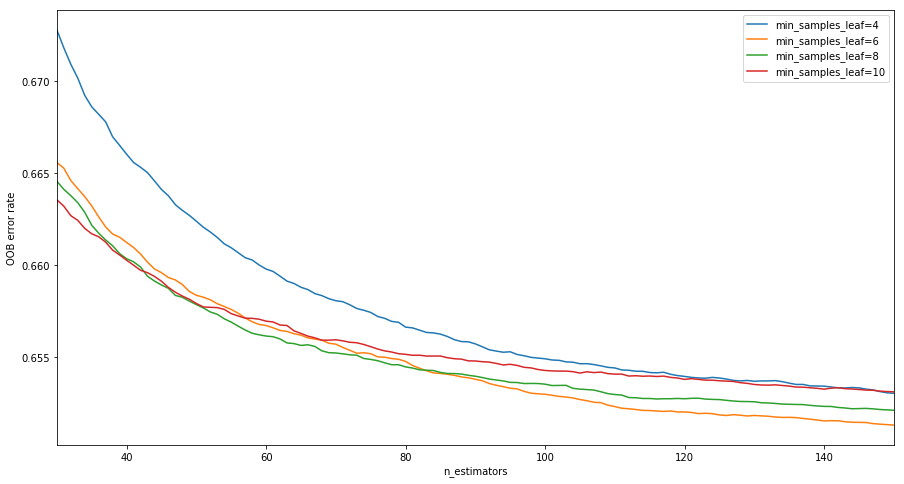

In [255]:
optimization_of_parameter_of_rf(train.iloc[:,1:].values, train.rating.values,{'max_features':50},'min_samples_leaf',[4,6,8,10],30,150)

In [256]:
rfr=RandomForestRegressor(n_estimators=300, max_features=50,  min_samples_leaf=6)
rfr.fit(train.iloc[:,1:].values, train.rating.values)
pred_=rfr.predict(test.iloc[:,1:].values)
mean_squared_error(test.rating.values,pred_)

0.9148268740246499

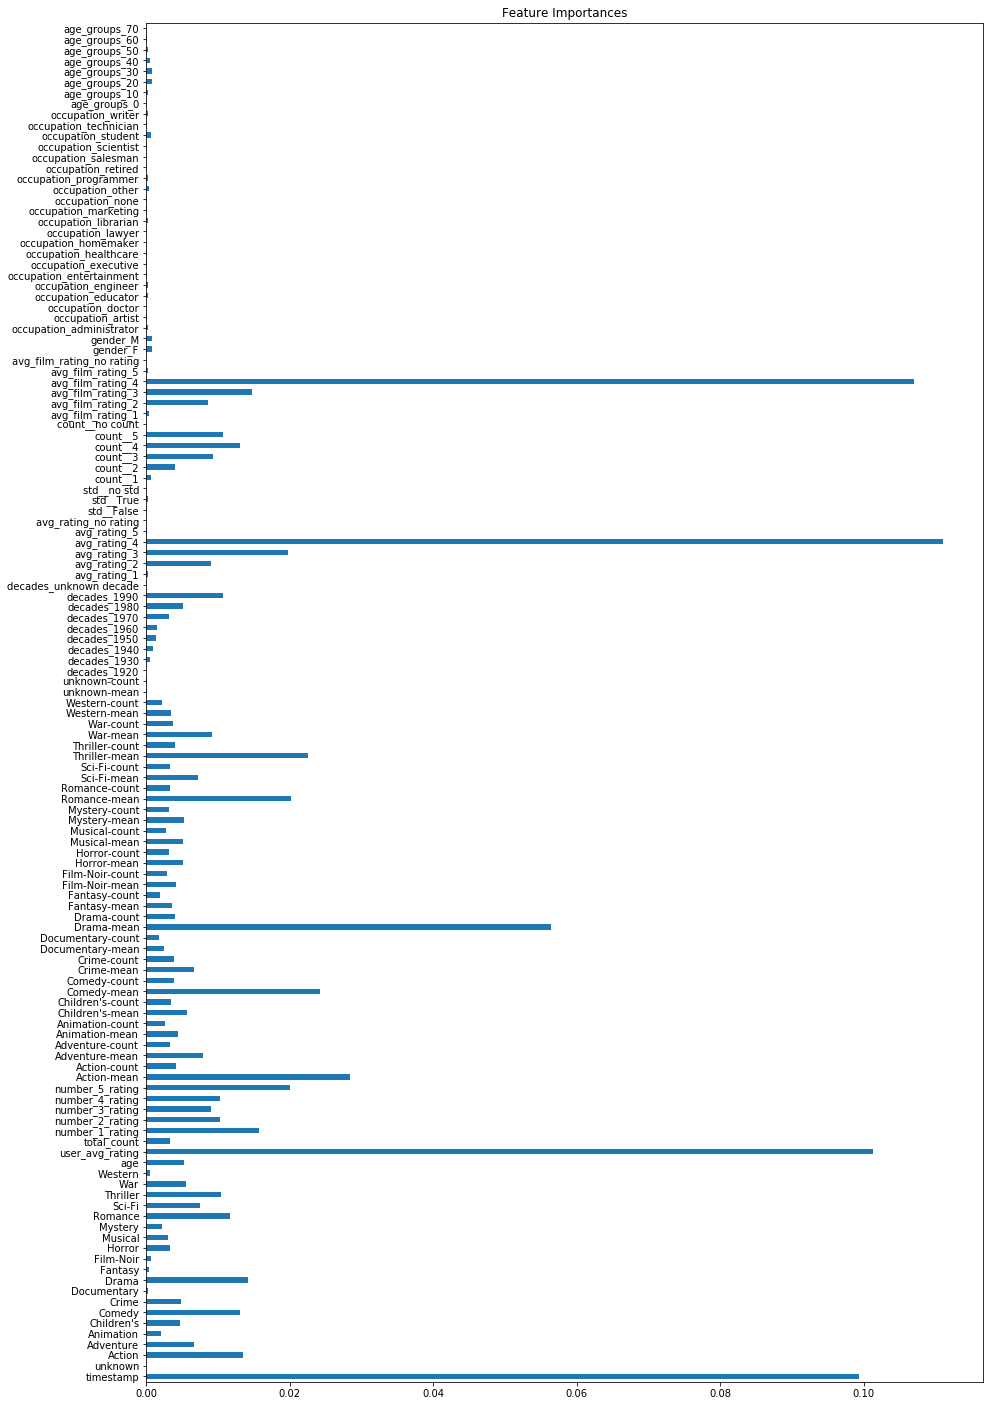

In [269]:
plt.figure(figsize=(15,25))
plt.title('Feature Importances')
pd.Series(rfr.feature_importances_,train.iloc[:,1:].columns).plot(kind='barh')